# Electron Photon tagging

This is a first test to implement a QAE and compare it to a classical AE.  
The task is to identify Electrons and Photons from em-calorimeter images.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
import tensorflow as tf
import tensorflow_quantum as tfq
from hep_VQAE import data_preprocessing as dp


import warnings
warnings.filterwarnings('ignore')

2022-06-13 16:33:16.549462: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-13 16:33:16.549492: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-06-13 16:33:18.550081: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-13 16:33:18.550116: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-13 16:33:18.550140: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tomskopfbahnhof): /proc/driver/nvidia/version does not exist
2022-06-13 16:33:18.550465: I tensorflow/core/platform/cpu_fe

In [2]:
data = np.load('data/electron-photon.npz', allow_pickle=True)
x_train = data['x_train']
x_test = data['x_test']
y_train = data['y_train']
y_test = data['y_test']
print("x_train: ", x_train.shape)
print("x_test: ", x_test.shape)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

x_train:  (100, 32, 32)
x_test:  (100, 32, 32)
y_train:  (100,)
y_test:  (100,)


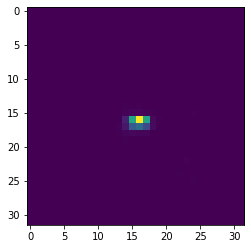

In [3]:
plt.imshow(x_train[0])

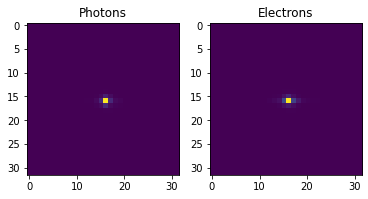

In [4]:
fig, axs = plt.subplots(1,2)

axs[0].imshow(np.average(x_train[y_train==0],0))
axs[0].title.set_text('Photons')

axs[1].imshow(np.average(x_train[y_train==1],0))
axs[1].title.set_text('Electrons')

# Dimensionality reduction

To use the QAE we need to reduce the dimension as only a couple of qbits are available.
The easiest way is a simple PCA.

In [5]:
DATA_DIMENSION = 9 
x_train = dp.PCA_reduce(x_train,DATA_DIMENSION)
x_test = dp.PCA_reduce(x_test,DATA_DIMENSION)
x_train.shape

(100, 9)

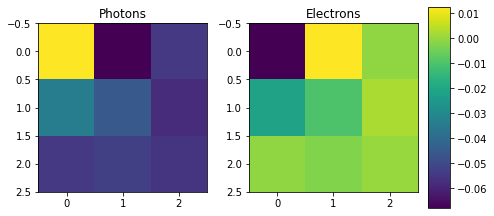

In [6]:
fig, axs = plt.subplots(1,2)
img0 = axs[0].imshow(np.average(x_train[y_train==0],0).reshape(3,3))
axs[0].title.set_text('Photons')

img1 = axs[1].imshow(np.average(x_train[y_train==1],0).reshape(3,3))
axs[1].title.set_text('Electrons')

cbar_ax = fig.add_axes([1, 0.15, 0.05, 0.7])
fig.colorbar(img1, orientation='vertical', cax=cbar_ax)
fig.tight_layout()

After the PCA it looks like Photons and Electrons should still seperate quite well.

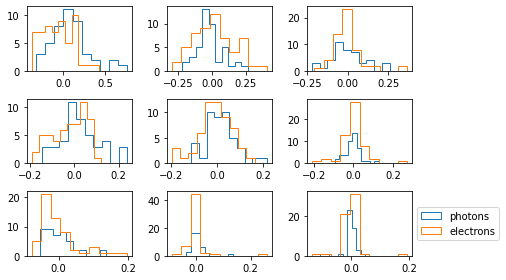

In [7]:
fig, axs = plt.subplots(3,3)
for i in range(0,9):
    axs[i//3,i%3].hist(x_train[y_train==0][:,i], label="photons", histtype='step')
    axs[i//3,i%3].hist(x_train[y_train==1][:,i], label="electrons", histtype='step')
fig.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# QAE

First simple implementation of a QAE

In [8]:
x_train_circuit = [dp.data_to_circuit(x) for x in x_train]
x_test_circuit = [dp.data_to_circuit(x) for x in x_test]

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


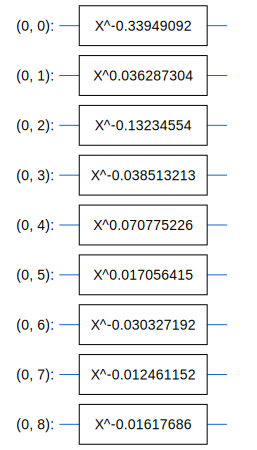

In [10]:
SVGCircuit(x_train_circuit[0])

In [13]:
x_train_tf = tfq.convert_to_tensor(x_train_circuit)
x_test_tf = tfq.convert_to_tensor(x_test_circuit)